# Testing Notebook
This notebook loads the validation dataset and the trained model, evaluates performance, and visualizes incorrect predictions.

In [23]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [24]:
class GreekLettersDataset(Dataset):
    def __init__(self, x, t, transform=None):
        self.x = x
        self.t = t
        self.transform = transform

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        # Ensure the data is reshaped correctly
        img = self.x[idx].reshape(100, 100).astype(np.float32)
        img = np.stack([img] * 3, axis=0)  # Convert to 3 channels
        if self.transform:
            img = self.transform(torch.tensor(img))
        else:
            img = torch.tensor(img, dtype=torch.float32) / 255.0
        label = self.t[idx]
        return img, label
    
# Label mapping for Greek letters    
label_map = { 
    0: 'alpha', 1: 'beta', 2: 'gamma', 3: 'delta', 4: 'epsilon', 5: 'eta', 6: 'theta', 7: 'lambda', 8: 'mu', 9: 'pi' 
}

# Testing Function

In [58]:
def test(x_test, t_test, device, model_path, display_images=5):
    """
    Test the trained model on the validation dataset and visualize incorrect predictions.

    Args:
        x_test        : Numpy array of test features.
        t_test        : Numpy array of test labels.
        device        : Device to run the model on (CPU or GPU).
        display_images: Number of incorrect predictions to visualize.
        model_path    : Path to the saved model.

    Returns:
        accuracy      : The accuracy of the model on the test dataset.
        incorrect_preds: List of incorrect predictions.
    """
    print("Starting Testing...\n")

    # Transformations for the dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Normalize([0.5] * 3, [0.5] * 3)
    ])

    # Create the dataset and dataloader
    dataset = GreekLettersDataset(x_test, t_test, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Load the trained model
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 10)  # Ensure this matches the training script

    try:
        model.load_state_dict(torch.load(model_path))  # Load the saved model
        print(f"Model loaded successfully from {model_path}")
    except RuntimeError as e:
        print(f"Error loading model: {e}")
        return

    model = model.to(device)
    model.eval()

    # Initialize metrics
    correct = 0
    total = 0
    incorrect_preds = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    print("Evaluating the model...")
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)

            # Update metrics
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Collect incorrect predictions
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    incorrect_preds.append(preds[i].item())
                    incorrect_images.append(imgs[i].cpu().numpy())
                    incorrect_labels.append(labels[i].item())
                    incorrect_predictions.append(preds[i].item())

    # Calculate accuracy
    accuracy = correct / total
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nTesting complete.")

    # Visualize incorrect predictions
    num_incorrect = min(display_images, len(incorrect_images))
    if num_incorrect > 0:
        print(f"\nVisualizing {num_incorrect} incorrect predictions:")

        cols = 5  # Number of images per row
        rows = (num_incorrect + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
        axes = axes.flatten()

        for i in range(num_incorrect):
            img = incorrect_images[i].transpose(1, 2, 0)[:, :, 0]  # Convert to grayscale
            true_letter = label_map[incorrect_labels[i]]
            pred_letter = label_map[incorrect_predictions[i]]
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"True: {true_letter}\nPred: {pred_letter}")
            axes[i].axis('off')

        for i in range(num_incorrect, len(axes)):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No incorrect predictions to visualize.")

    return accuracy, incorrect_preds

# Execution

In [67]:
# Input path declarations (Modify as needed)
x_path = '../data/generated/x_test_split.csv'
t_path = '../data/generated/t_test_split.csv'
#model_path = 'final_model.pt'
model_path = 'best_model.pt'  # Change to the best model path if needed

In [43]:
# Load the test data
x_test = pd.read_csv(x_path, header=None).values.astype(np.float32)
t_test = pd.read_csv(t_path, header=None).values.flatten().astype(np.int64)

In [44]:
# Define the device for training (GPU in personal environment/CPU in Test environment)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

Device Name: NVIDIA GeForce RTX 3080


Starting Testing...

Model loaded successfully from best_model.pt
Evaluating the model...

Test Accuracy: 0.9925

Testing complete.

Visualizing 9 incorrect predictions:


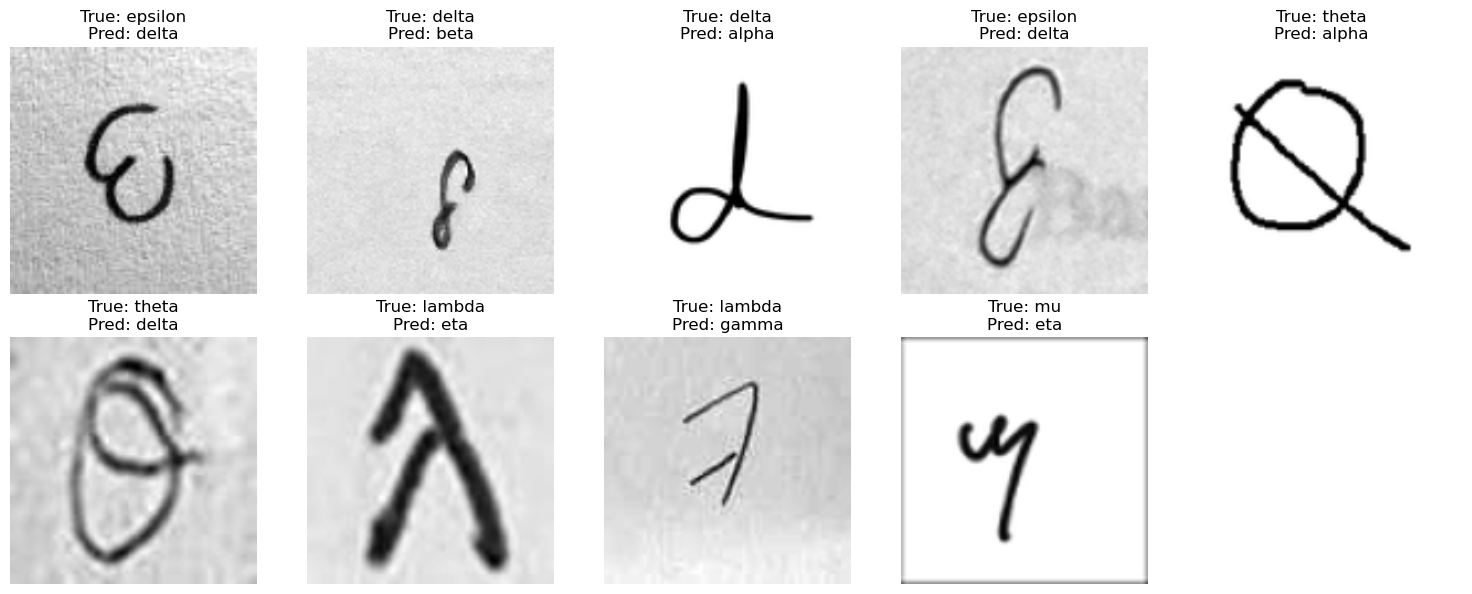

In [68]:
accuracy, incorrect_predictions = test(x_test, t_test, device, model_path, display_images=10)